# Similarity of left and right profiles of sea turtles

This notebook analyzes the differences between left and right profiles for sea turtles. We analyzed three different species (loggerheads, grees and hawksbills) with the uniform conclusion that there is a significant similarity between opposite profile in all three species. The main conclusion of this observation is that biologists should used both profiles for identifying individuals and not only the same profile as the current practise goes.

We first load the required packages and functions.

In [2]:
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from sides_matching import Prediction, MegaDescriptor, Aliked, Combined, Sift, TORSOOI
from sides_matching import get_transform, get_box_plot_data, unpack, visualise_matches
from sides_matching import amvrakikos, reunion_green, reunion_hawksbill, zakynthos

/home/sadda/Projects/sides-matching/venv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


We already assume that the data were downloaded and the features extracted. If this is not the case, please run first [this notebook](compute_features.ipynb). The next codes specifies the folders whether data are stored and where results will be saved. The variable 'data' states that we will run experiments on datasets ZakynthosTurtles, AmvrakikosTurtles and ReunionTurtles, while the last dataset will be analyzed separately for green and hawksbill turtles. Concerning methods, we will use MegaDescriptor, SIFT and TORSOOI codes.

In [3]:
img_size = 384
root_data = '/data/wildlife_datasets/data'
root_features = '../features'
root_figures = '../figures'
root_images = '../images'
data = [
    ('Zakynthos', os.path.join(root_data, 'ZakynthosTurtles'), zakynthos, 'MegaDescriptor'),
    ('Amvrakikos', os.path.join(root_data, 'AmvrakikosTurtles'), amvrakikos, 'MegaDescriptor'),
    ('ReunionGreen', os.path.join(root_data, 'ReunionTurtles'), reunion_green, 'MegaDescriptor'),
    ('ReunionHawksbill', os.path.join(root_data, 'ReunionTurtles'), reunion_hawksbill, 'MegaDescriptor'),
    ('Zakynthos', os.path.join(root_data, 'ZakynthosTurtles'), zakynthos, 'Aliked'),
    ('Amvrakikos', os.path.join(root_data, 'AmvrakikosTurtles'), amvrakikos, 'Aliked'),
    ('ReunionGreen', os.path.join(root_data, 'ReunionTurtles'), reunion_green, 'Aliked'),
    ('ReunionHawksbill', os.path.join(root_data, 'ReunionTurtles'), reunion_hawksbill, 'Aliked'),
    ('ReunionGreen', os.path.join(root_data, 'ReunionTurtles'), reunion_green, 'TORSOOI'),
    ('ReunionHawksbill', os.path.join(root_data, 'ReunionTurtles'), reunion_hawksbill, 'TORSOOI'),
]
data = [
    ('Zakynthos', os.path.join(root_data, 'ZakynthosTurtles'), zakynthos, 'MegaDescriptor'),
    ('Amvrakikos', os.path.join(root_data, 'AmvrakikosTurtles'), amvrakikos, 'MegaDescriptor'),
    ('ReunionGreen', os.path.join(root_data, 'ReunionTurtles'), reunion_green, 'MegaDescriptor'),
    ('ReunionHawksbill', os.path.join(root_data, 'ReunionTurtles'), reunion_hawksbill, 'MegaDescriptor'),
    ('Zakynthos', os.path.join(root_data, 'ZakynthosTurtles'), zakynthos, 'Aliked'),
    ('Amvrakikos', os.path.join(root_data, 'AmvrakikosTurtles'), amvrakikos, 'Aliked'),
    ('ReunionGreen', os.path.join(root_data, 'ReunionTurtles'), reunion_green, 'Aliked'),
    ('ReunionHawksbill', os.path.join(root_data, 'ReunionTurtles'), reunion_hawksbill, 'Aliked'),
    ('ReunionGreen', os.path.join(root_data, 'ReunionTurtles'), reunion_green, 'TORSOOI'),
    ('ReunionHawksbill', os.path.join(root_data, 'ReunionTurtles'), reunion_hawksbill, 'TORSOOI'),
    ('Zakynthos', os.path.join(root_data, 'ZakynthosTurtles'), zakynthos, 'AlikedCombined'),
    ('Amvrakikos', os.path.join(root_data, 'AmvrakikosTurtles'), amvrakikos, 'AlikedCombined'),
    ('ReunionGreen', os.path.join(root_data, 'ReunionTurtles'), reunion_green, 'AlikedCombined'),
    ('ReunionHawksbill', os.path.join(root_data, 'ReunionTurtles'), reunion_hawksbill, 'AlikedCombined'),
]


for root in [root_features, root_figures, root_images]:
    os.makedirs(root, exist_ok=True)
names_datasets = [x[0] for x in data]
names_methods = [x[-1] for x in data]
data_index = pd.MultiIndex.from_arrays([names_methods, names_datasets], names=['Method', 'Dataset'])

The next code computes the scores and predictions for the query images. The scores are computed for pairs are of images. The computations of scores is as follows:

- MegaDescriptor: the cosine similarity between the extracted features.
- SIFT: the negative distance between 15 closest descriptors.
- TORSOOI: the number of matching number of edges from TORSOOI codes.

The predictions are computed as the images with the highest similarity to the query image. We return not only the usual top-1 prediction but a sorted array of all scores. 

In [4]:
datasets = {x: {} for x in [True, False]}
predictions = {x: {} for x in [True, False]}
grayscale = False
for (name, root, dataset_class, metric), index in zip(data, data_index):
    for flip in [True, False]:
        # Load dataset
        transform = get_transform(flip=flip, grayscale=grayscale, img_size=img_size, normalize=False)
        dataset = dataset_class(root, transform=transform)
        # Define score_computer for each method
        if metric == 'MegaDescriptor':
            path_features_database = os.path.join(root_features, f'MegaDescriptor_{name}_flip={False}_grayscale={grayscale}.pickle')
            path_features_query = os.path.join(root_features, f'MegaDescriptor_{name}_flip={flip}_grayscale={grayscale}.pickle')
            score_computer = MegaDescriptor(path_features_query, path_features_database)
        elif metric == 'Aliked':
            path_features_database = os.path.join(root_features, f'Aliked_{name}_flip={False}_grayscale={grayscale}_{img_size}.pickle')
            path_features_query = os.path.join(root_features, f'Aliked_{name}_flip={flip}_grayscale={grayscale}_{img_size}.pickle')
            score_computer = Aliked(path_features_query, path_features_database)
        elif metric == 'Sift':
            path_features_database = os.path.join(root_features, f'Sift_{name}_flip={False}_grayscale={grayscale}_{img_size}.pickle')
            path_features_query = os.path.join(root_features, f'Sift_{name}_flip={flip}_grayscale={grayscale}_{img_size}.pickle')
            score_computer = Sift(path_features_query, path_features_database)
        elif metric == 'TORSOOI':
            score_computer = TORSOOI(dataset.df)
        elif metric == 'MegaDescriptorCombined':
            prediction0 = predictions[False][('MegaDescriptor', name)]
            prediction1 = predictions[True][('MegaDescriptor', name)]
            score_computer = Combined(prediction0, prediction1)
        elif metric == 'AlikedCombined':
            prediction0 = predictions[False][('Aliked', name)]
            prediction1 = predictions[True][('Aliked', name)]
            score_computer = Combined(prediction0, prediction1)
        else:
            raise Exception('Metric now known')
        # Compute scores and predictions based on closest scores        
        similarity = score_computer.compute_similarity(ignore='diagonal')
        prediction = Prediction(dataset.df, similarity, k=len(dataset)-1)
        predictions[flip][index] = prediction
        datasets[flip][index] = dataset

/home/sadda/Projects/sides-matching/venv/lib/python3.10/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
100%|█████████████████████████████████████████████████████████████| 145/145 [00:49<00:00,  2.94it/s]


From the predictions, the accuracy is computed. The top-1 accuracy is the standard accuracy, which computes the ratio of correct matches of the closests predictions. Top-k accuracy is deemed a success when at least one of the top-k sorted predictions is a success (the prediction is the same as the true identity).

In [5]:
mods = ['full', 'same year', 'same orientation', 'different both', 'different year']
mods_text = ['all images', 'A: diff side, same year', 'B: same side, diff year', 'C: diff side, diff year', 'B+C: any side, diff year']
for flip in [True, False]:
    for _, prediction in predictions[flip].items():
        prediction.compute_accuracy(mods)

We now plot the accuracy for all methods and all datasets. The images are saved into the `root_figures` folder. As an example, one figure is plotted in this notebook as well.

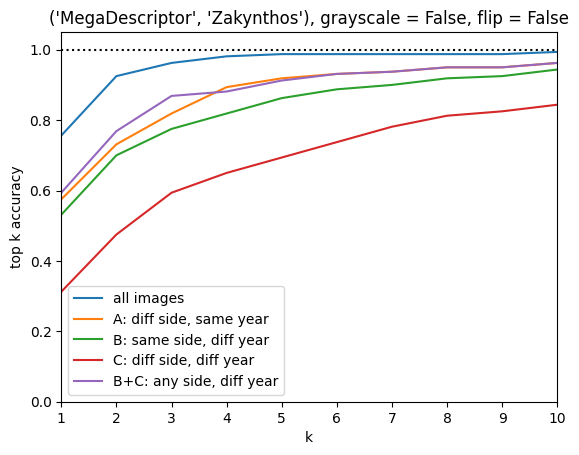

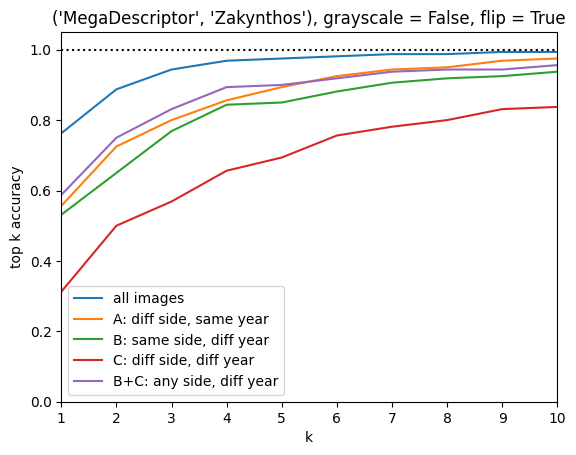

In [6]:
for flip in [False, True]:
    for i_name, index in enumerate(data_index):
        prediction = predictions[flip][index]
        xs = range(1, 1+prediction.n_individuals)
        df_save = pd.DataFrame()
        df_save['k'] = xs
        plt.figure()
        for mod in mods:
            ys = [prediction.accuracy[mod][f'top {i}'] for i in xs]
            df_save[mod] = ys
            plt.plot(xs, ys)
        df_save.to_csv(os.path.join(root_figures, f'accuracy_{grayscale}_{flip}_{unpack(index)}.csv'), index=False)
        plt.axhline(1, color='black', linestyle='dotted')
        plt.xlim([1, 10])
        plt.ylim([0, 1.05])
        plt.xlabel('k')
        plt.ylabel('top k accuracy')
        plt.legend(mods_text)
        plt.title(f'{index}, grayscale = {grayscale}, flip = {flip}')
        plt.savefig(os.path.join(root_figures, f'accuracy_{grayscale}_{flip}_{unpack(index)}.png'), bbox_inches='tight')
        if i_name > 0:
            plt.close()

The previous figures may be visualized as a table. We show the top-5 accuracy for all methods and all datasets.

In [7]:
metric = 'top 5'
accuracy_top = {x: {mod: [] for mod in mods} for x in [True, False]}    
for flip in [True, False]:
    for index in data_index:
        prediction = predictions[flip][index]
        for mod in mods:
            accuracy_top[flip][mod].append(prediction.accuracy[mod][metric])
    df_save = pd.DataFrame(accuracy_top[flip], index=data_index)
    df_latex = df_save.to_latex(float_format='%.3f')
    print(f'Grayscale = {grayscale}. Flip = {flip}')
    display(df_save)
    with open(os.path.join(root_figures, f'accuracy_{grayscale}_{flip}_{metric}.txt'), 'w') as file:
        file.write(df_latex)

Grayscale = False. Flip = True


full  same year  same orientation  \
Method         Dataset                                                   
MegaDescriptor Zakynthos         0.975000   0.893750          0.850000   
               Amvrakikos        0.760000   0.685000          0.340000   
               ReunionGreen      0.840000   0.770000          0.280000   
               ReunionHawksbill  0.875000   0.823529          0.367647   
Aliked         Zakynthos         0.625000   0.387500          0.006250   
               Amvrakikos        0.655000   0.495000          0.005000   
               ReunionGreen      0.845000   0.720000          0.000000   
               ReunionHawksbill  0.757353   0.617647          0.000000   
TORSOOI        ReunionGreen      0.780000   0.315000          0.720000   
               ReunionHawksbill  0.617647   0.183824          0.507353   
AlikedCombined Zakynthos         0.825000   0.312500          0.725000   
               Amvrakikos        0.855000   0.365000          0.740000   
               ReunionGreen      0.925000   0.665000          0.785000   
               ReunionHawksbill  0.830882   0.566176          0.500000   

                                 different both  different year  
Method         Dataset                                           
MegaDescriptor Zakynthos               0.693750        0.900000  
               Amvrakikos              0.230000        0.405000  
               ReunionGreen            0.260000        0.375000  
               ReunionHawksbill        0.294118        0.441176  
Aliked         Zakynthos               0.406250        0.412500  
               Amvrakikos              0.280000        0.280000  
               ReunionGreen            0.555000        0.555000  
               ReunionHawksbill        0.382353        0.382353  
TORSOOI        ReunionGreen            0.265000        0.765000  
               ReunionHawksbill        0.139706        0.558824  
AlikedCombined Zakynthos               0.275000        0.793750  
               Amvrakikos              0.185000        0.775000  
               ReunionGreen            0.470000        0.835000  
               ReunionHawksbill        0.286765        0.610294

Grayscale = False. Flip = False


full  same year  same orientation  \
Method         Dataset                                                   
MegaDescriptor Zakynthos         0.987500   0.918750          0.862500   
               Amvrakikos        0.795000   0.730000          0.360000   
               ReunionGreen      0.830000   0.765000          0.260000   
               ReunionHawksbill  0.882353   0.838235          0.389706   
Aliked         Zakynthos         0.750000   0.018750          0.737500   
               Amvrakikos        0.805000   0.005000          0.805000   
               ReunionGreen      0.830000   0.000000          0.830000   
               ReunionHawksbill  0.617647   0.007353          0.610294   
TORSOOI        ReunionGreen      0.780000   0.315000          0.720000   
               ReunionHawksbill  0.617647   0.183824          0.507353   
AlikedCombined Zakynthos         0.825000   0.312500          0.725000   
               Amvrakikos        0.855000   0.365000          0.740000   
               ReunionGreen      0.925000   0.665000          0.785000   
               ReunionHawksbill  0.830882   0.566176          0.500000   

                                 different both  different year  
Method         Dataset                                           
MegaDescriptor Zakynthos               0.693750        0.912500  
               Amvrakikos              0.225000        0.420000  
               ReunionGreen            0.255000        0.350000  
               ReunionHawksbill        0.323529        0.463235  
Aliked         Zakynthos               0.006250        0.743750  
               Amvrakikos              0.000000        0.805000  
               ReunionGreen            0.000000        0.830000  
               ReunionHawksbill        0.000000        0.610294  
TORSOOI        ReunionGreen            0.265000        0.765000  
               ReunionHawksbill        0.139706        0.558824  
AlikedCombined Zakynthos               0.275000        0.793750  
               Amvrakikos              0.185000        0.775000  
               ReunionGreen            0.470000        0.835000  
               ReunionHawksbill        0.286765        0.610294

In [8]:
prediction0 = predictions[False][data_index[4]]
prediction1 = predictions[True][data_index[4]]
correct0 = prediction0.pred_label[:,0] == prediction0.true_label
correct1 = prediction1.pred_label[:,0] == prediction1.true_label
correct = np.where(correct0 * correct1)[0]
i_plot = correct[2]

In [9]:
from wildlife_tools.similarity import MatchLightGlue
from wildlife_tools.similarity.pairwise.collectors import CollectAll

matcher = MatchLightGlue(features='aliked', collector=CollectAll())
index = data_index.values[4]
_, name = index
dataset_False = datasets[False][index]
dataset_True = datasets[True][index]

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.88it/s]


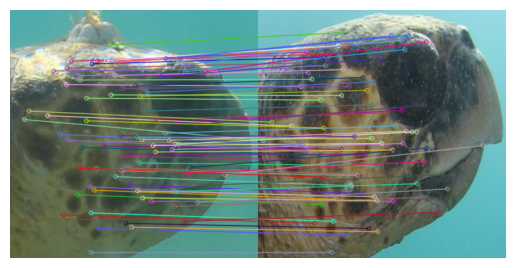

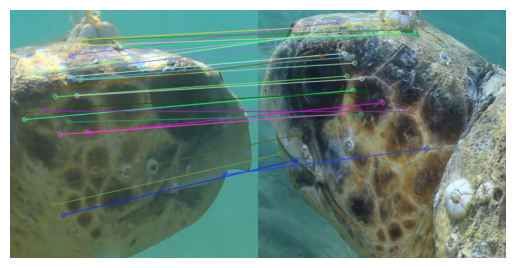

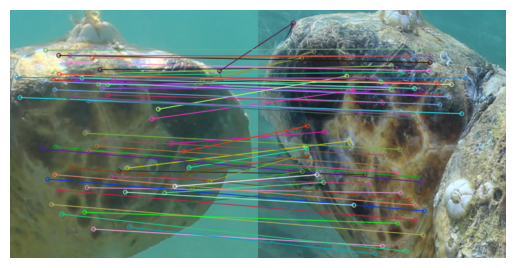

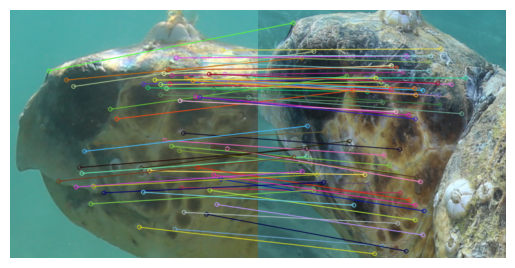

In [10]:
prediction = predictions[False][index]
j_False = prediction.pred[i_plot, 0]
prediction = predictions[True][index]
j_True = prediction.pred[i_plot, 0]

flip = False
path_features_database = os.path.join(root_features, f'Aliked_{name}_flip={False}_grayscale={grayscale}_{img_size}.pickle')
path_features_query = os.path.join(root_features, f'Aliked_{name}_flip={flip}_grayscale={grayscale}_{img_size}.pickle')
score_computer = Aliked(path_features_query, path_features_database)
features_query, features_database = score_computer.get_features()

matches = matcher(features_query, features_database, pairs=[(i_plot, j_False)])
visualise_matches(dataset_False[i_plot], matches[0]['kpts0'], dataset_False[j_False], matches[0]['kpts1'])
plt.savefig(f'Matches0_{len(matches[0]["scores"])}.png', bbox_inches='tight', dpi=300)
matches = matcher(features_query, features_database, pairs=[(i_plot, j_True)])
visualise_matches(dataset_False[i_plot], matches[0]['kpts0'], dataset_False[j_True], matches[0]['kpts1'])
plt.savefig(f'Matches1_{len(matches[0]["scores"])}.png', bbox_inches='tight', dpi=300)

flip = True
path_features_database = os.path.join(root_features, f'Aliked_{name}_flip={False}_grayscale={grayscale}_{img_size}.pickle')
path_features_query = os.path.join(root_features, f'Aliked_{name}_flip={flip}_grayscale={grayscale}_{img_size}.pickle')
score_computer = Aliked(path_features_query, path_features_database)
features_query, features_database = score_computer.get_features()

matches = matcher(features_query, features_database, pairs=[(i_plot, j_True)])
visualise_matches(dataset_True[i_plot], matches[0]['kpts0'], dataset_False[j_True], matches[0]['kpts1'], flip_img0=True)
plt.savefig(f'Matches2_{len(matches[0]["scores"])}.png', bbox_inches='tight', dpi=300)
matches = matcher(features_query, features_database, pairs=[(i_plot, j_True)])
visualise_matches(dataset_True[i_plot], matches[0]['kpts0'], dataset_False[j_True], matches[0]['kpts1'])
plt.savefig(f'Matches3_{len(matches[0]["scores"])}.png', bbox_inches='tight', dpi=300)

The next code graphically shows the boxplot of all similarities for the various settings mentioned in the paper. As in the previous case, all figures are saved into `root_figures` and only one is plotted here.

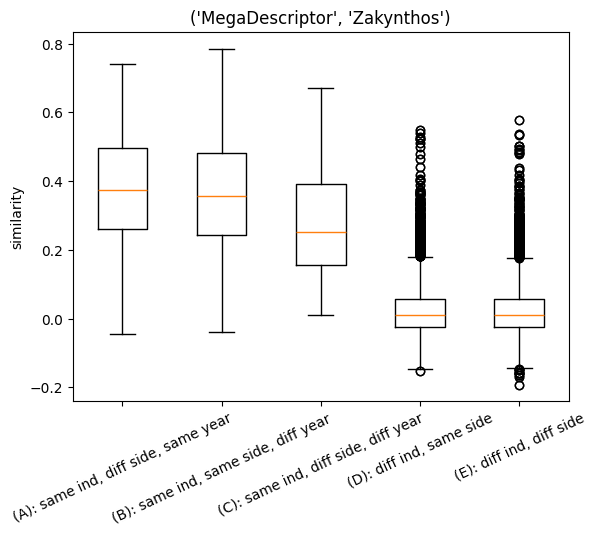

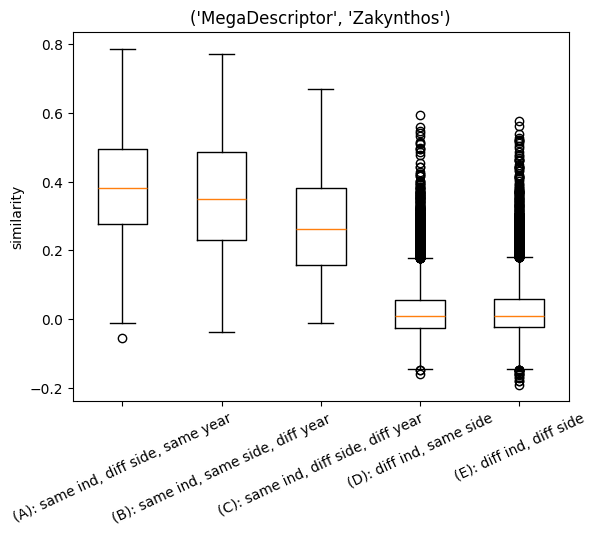

In [11]:
p_values = {x: {index: {} for index in data_index} for x in [True, False]}
boxplot_data = {x: {index: {} for index in data_index} for x in [True, False]}
for flip in [False, True]:
    for i_name, index in enumerate(data_index):
        similarity_split = predictions[flip][index].split_scores()
        similarity_boxplot = [
            # identity, orientation, year
            similarity_split[True][False][True],
            similarity_split[True][True][False],
            similarity_split[True][False][False],
            similarity_split[False][True][True] + similarity_split[False][True][False],
            similarity_split[False][False][True] + similarity_split[False][False][False],
        ]
        names_boxplot = [
            '(A): same ind, diff side, same year',
            '(B): same ind, same side, diff year',
            '(C): same ind, diff side, diff year',
            '(D): diff ind, same side',
            '(E): diff ind, diff side',
        ]

        for i in range(len(similarity_boxplot)):
            similarity_boxplot[i] = np.array(similarity_boxplot[i])[np.isfinite(similarity_boxplot[i])]
        
        for i in range(5):
            for j in range(i+1,5):
                _, p_value = ttest_ind(similarity_boxplot[i], similarity_boxplot[j], alternative='two-sided')
                p_values[flip][index][f'{i}!={j}'] = np.round(p_value, 3)

        plt.figure()
        fig = plt.boxplot(similarity_boxplot)
        plt.xticks(range(1, len(names_boxplot)+1), names_boxplot, rotation=25)
        plt.ylabel('similarity')
        plt.title(index)
        plt.savefig(os.path.join(root_figures, f'similarity_{grayscale}_{flip}_{unpack(index)}.png'), bbox_inches='tight')
        if i_name > 0:
            plt.close()
        boxplot_data[flip][index] = get_box_plot_data(fig)

We show the p-values that the individual settings have the same similarity scores.

In [12]:
# TODO: needs to be rewritten based on the new assumptions
for flip in [False, True]:
    df_save = pd.DataFrame(p_values[flip]).T.set_index(data_index)
    df_latex = df_save.to_latex(float_format='%.3f')
    print(f'Grayscale = {grayscale}. Flip = {flip}')
    display(df_save)
    with open(os.path.join(root_figures, f'pvalues_{grayscale}_{flip}_{metric}.txt'), 'w') as file:
        file.write(df_latex)

Grayscale = False. Flip = False


0!=1   0!=2  0!=3   0!=4   1!=2  1!=3  1!=4  \
Method         Dataset                                                          
MegaDescriptor Zakynthos         0.380  0.000   0.0  0.000  0.000   0.0   0.0   
               Amvrakikos        0.000  0.000   0.0  0.000  0.003   0.0   0.0   
               ReunionGreen      0.000  0.000   0.0  0.000  0.669   0.0   0.0   
               ReunionHawksbill  0.000  0.000   0.0  0.000  0.477   0.0   0.0   
Aliked         Zakynthos         0.000  0.094   0.0  0.554  0.000   0.0   0.0   
               Amvrakikos        0.000  0.142   0.0  0.204  0.000   0.0   0.0   
               ReunionGreen      0.000  0.110   0.0  0.019  0.000   0.0   0.0   
               ReunionHawksbill  0.000  0.009   0.0  0.000  0.000   0.0   0.0   
TORSOOI        ReunionGreen      0.000  0.368   0.0  0.000  0.000   0.0   0.0   
               ReunionHawksbill  0.000  0.132   0.0  0.000  0.000   0.0   0.0   
AlikedCombined Zakynthos         0.000  0.190   0.0  0.000  0.000   0.0   0.0   
               Amvrakikos        0.000  0.000   0.0  0.000  0.000   0.0   0.0   
               ReunionGreen      0.000  0.000   0.0  0.000  0.000   0.0   0.0   
               ReunionHawksbill  0.082  0.000   0.0  0.000  0.001   0.0   0.0   

                                  2!=3   2!=4   3!=4  
Method         Dataset                                
MegaDescriptor Zakynthos         0.000  0.000  0.340  
               Amvrakikos        0.000  0.000  0.625  
               ReunionGreen      0.000  0.000  0.379  
               ReunionHawksbill  0.000  0.000  0.464  
Aliked         Zakynthos         0.000  0.068  0.000  
               Amvrakikos        0.000  0.302  0.000  
               ReunionGreen      0.000  0.859  0.000  
               ReunionHawksbill  0.000  0.953  0.000  
TORSOOI        ReunionGreen      0.000  0.000  0.980  
               ReunionHawksbill  0.014  0.018  0.587  
AlikedCombined Zakynthos         0.000  0.000  0.929  
               Amvrakikos        0.000  0.000  0.000  
               ReunionGreen      0.000  0.000  0.715  
               ReunionHawksbill  0.000  0.000  0.199

Grayscale = False. Flip = True


0!=1   0!=2  0!=3  0!=4   1!=2   1!=3  1!=4  \
Method         Dataset                                                          
MegaDescriptor Zakynthos         0.254  0.000   0.0   0.0  0.000  0.000   0.0   
               Amvrakikos        0.000  0.000   0.0   0.0  0.007  0.000   0.0   
               ReunionGreen      0.000  0.000   0.0   0.0  0.770  0.000   0.0   
               ReunionHawksbill  0.000  0.000   0.0   0.0  0.585  0.000   0.0   
Aliked         Zakynthos         0.000  0.236   0.0   0.0  0.000  0.259   0.0   
               Amvrakikos        0.000  0.000   0.0   0.0  0.000  0.303   0.0   
               ReunionGreen      0.000  0.000   0.0   0.0  0.000  0.345   0.0   
               ReunionHawksbill  0.000  0.000   0.0   0.0  0.000  0.018   0.0   
TORSOOI        ReunionGreen      0.000  0.368   0.0   0.0  0.000  0.000   0.0   
               ReunionHawksbill  0.000  0.132   0.0   0.0  0.000  0.000   0.0   
AlikedCombined Zakynthos         0.000  0.190   0.0   0.0  0.000  0.000   0.0   
               Amvrakikos        0.000  0.000   0.0   0.0  0.000  0.000   0.0   
               ReunionGreen      0.000  0.000   0.0   0.0  0.000  0.000   0.0   
               ReunionHawksbill  0.082  0.000   0.0   0.0  0.001  0.000   0.0   

                                  2!=3   2!=4   3!=4  
Method         Dataset                                
MegaDescriptor Zakynthos         0.000  0.000  0.569  
               Amvrakikos        0.000  0.000  0.766  
               ReunionGreen      0.000  0.000  0.984  
               ReunionHawksbill  0.000  0.000  0.445  
Aliked         Zakynthos         0.000  0.000  0.000  
               Amvrakikos        0.000  0.000  0.000  
               ReunionGreen      0.000  0.000  0.000  
               ReunionHawksbill  0.000  0.000  0.000  
TORSOOI        ReunionGreen      0.000  0.000  0.980  
               ReunionHawksbill  0.014  0.018  0.587  
AlikedCombined Zakynthos         0.000  0.000  0.929  
               Amvrakikos        0.000  0.000  0.000  
               ReunionGreen      0.000  0.000  0.715  
               ReunionHawksbill  0.000  0.000  0.199

In [13]:
flags = [
    'col1, ylabel={Zakynthos-Loggerheads}, title={MegaDescriptor}, xticklabels={}',
    'col2, ylabel={}, title={ALIKED}, xticklabels={}, yticklabels={}',
    'col3, group/empty plot, title={TORSOOI}',
    'col1, ylabel={Amvrakikos-Loggerheads}, title={}, xticklabels={}',
    'col2, ylabel={}, title={}, xticklabels={}, yticklabels={}',
    'col3, group/empty plot, title={}',
    'col1, ylabel={Reunion-Greens}, title={}, xticklabels={}',
    'col2, ylabel={}, title={}, xticklabels={}, yticklabels={}',
    'col3, ylabel={}, title={}, xticklabels={}, yticklabels={}, cycle list={{myred}}',
    'col1, xlabel={similarity}, ylabel={Reunion-Hawksbills}, title={}',
    'col2, xlabel={similarity}, ylabel={}, title={}, yticklabels={}',
    'col3, xlabel={similarity}, ylabel={}, title={}, yticklabels={}, cycle list={{myred}},',
]
index_order = [
    ('MegaDescriptor', 'Zakynthos'),
    ('Aliked', 'Zakynthos'),
    None,
    ('MegaDescriptor', 'Amvrakikos'),
    ( 'Aliked', 'Amvrakikos'),
    None,
    ('MegaDescriptor', 'ReunionGreen'),
    ('Aliked', 'ReunionGreen'),
    ('TORSOOI', 'ReunionGreen'),
    ('MegaDescriptor', 'ReunionHawksbill'),
    ('Aliked', 'ReunionHawksbill'),
    ('TORSOOI', 'ReunionHawksbill')
]

box_w = 0.4
for index, flag in zip(index_order, flags):
    print(f'\\nextgroupplot[{flag}]')
    if index is not None:
        bp_data_False = boxplot_data[False][index][::-1]
        bp_data_True = boxplot_data[True][index][::-1]
        for i in range(len(bp_data_False)):
            row = bp_data_False.iloc[i]
            l_w = np.round(row["lower_whisker"],2)
            l_q = np.round(row["lower_quartile"],2)
            median = np.round(row["median"],2)
            u_q = np.round(row["upper_quartile"],2)
            u_w = np.round(row["upper_whisker"],2)
            print(f'\\addboxplot{{bp}}{{{median}}}{{{u_q}}}{{{l_q}}}{{{u_w}}}{{{l_w}}}{{draw position={i+1.01+box_w/2},box extend={box_w}}};')
            if index[0] != 'TORSOOI':
                row = bp_data_True.iloc[i]
                l_w = np.round(row["lower_whisker"],2)
                l_q = np.round(row["lower_quartile"],2)
                median = np.round(row["median"],2)
                u_q = np.round(row["upper_quartile"],2)
                u_w = np.round(row["upper_whisker"],2)
                print(f'\\addboxplot{{bp}}{{{median}}}{{{u_q}}}{{{l_q}}}{{{u_w}}}{{{l_w}}}{{draw position={i+0.99-box_w/2},box extend={box_w}}};')            

\nextgroupplot[col1, ylabel={Zakynthos-Loggerheads}, title={MegaDescriptor}, xticklabels={}]
\addboxplot{bp}{0.01}{0.06}{-0.02}{0.18}{-0.14}{draw position=1.21,box extend=0.4};
\addboxplot{bp}{0.01}{0.06}{-0.02}{0.18}{-0.14}{draw position=0.79,box extend=0.4};
\addboxplot{bp}{0.01}{0.06}{-0.02}{0.18}{-0.15}{draw position=2.21,box extend=0.4};
\addboxplot{bp}{0.01}{0.06}{-0.02}{0.18}{-0.15}{draw position=1.79,box extend=0.4};
\addboxplot{bp}{0.25}{0.39}{0.15}{0.67}{0.01}{draw position=3.21,box extend=0.4};
\addboxplot{bp}{0.26}{0.38}{0.16}{0.67}{-0.01}{draw position=2.79,box extend=0.4};
\addboxplot{bp}{0.36}{0.48}{0.24}{0.79}{-0.04}{draw position=4.21,box extend=0.4};
\addboxplot{bp}{0.35}{0.48}{0.23}{0.77}{-0.04}{draw position=3.79,box extend=0.4};
\addboxplot{bp}{0.37}{0.5}{0.26}{0.74}{-0.05}{draw position=5.21,box extend=0.4};
\addboxplot{bp}{0.38}{0.49}{0.28}{0.79}{-0.01}{draw position=4.79,box extend=0.4};
\nextgroupplot[col2, ylabel={}, title={ALIKED}, xticklabels={}, yticklabels

In [14]:
for flip in [False]:
    for index in data_index:
        dataset = datasets[flip][index]
        prediction = predictions[flip][index]
        similarity_split = prediction.split_scores(save_idx=True)
        similarity_boxplot = [
            # identity, orientation, year
            similarity_split[True][False][True],
            similarity_split[True][False][False],
        ]
        
        for i, sim in enumerate(similarity_boxplot):
            for score_selection in ['top', 'bottom']:
                sim = sorted(sim, key=lambda x: (x[0]))
                if score_selection == 'top':
                    sim = sim[::-1]
                idx1 = [sim[0][1], sim[0][2]] if prediction.orientation[sim[0][1]] == 'right' else [sim[0][2], sim[0][1]]
                idx2 = [sim[2][1], sim[2][2]] if prediction.orientation[sim[2][1]] == 'right' else [sim[2][2], sim[2][1]]
                idx = idx1 + idx2

                for j1, j2 in enumerate(idx):
                    dataset[j2].save(os.path.join(root_images, f'sim_{unpack(index)}_{score_selection}_{grayscale}_{flip}_{i}_{j1}.png'))